In [11]:
from pathlib import Path

import cv2
import numpy as np
import IPython
from skimage import io

In [4]:
!wget https://github.com/astaileyyoung/CineFace/raw/main/research/data/face_detection_yunet_2023mar.onnx

--2024-06-07 20:31:36--  https://github.com/astaileyyoung/CineFace/raw/main/research/data/face_detection_yunet_2023mar.onnx
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/astaileyyoung/CineFace/main/research/data/face_detection_yunet_2023mar.onnx [following]
--2024-06-07 20:31:36--  https://raw.githubusercontent.com/astaileyyoung/CineFace/main/research/data/face_detection_yunet_2023mar.onnx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232589 (227K) [application/octet-stream]
Saving to: ‘face_detection_yunet_2023mar.onnx’

face_detection_yune 100%[===================>] 227.14K  --.-KB/s    in

In [19]:
class FaceDetectorYunet():
    def __init__(self,
                  model_path='./face_detection_yunet_2023mar.onnx',
                  img_size=(300, 300),
                  threshold=0.5):
        self.model_path = model_path
        self.img_size = img_size
        self.fd = cv2.FaceDetectorYN_create(str(model_path),
                                            "",
                                            img_size,
                                            score_threshold=threshold)

    def draw_faces(self,
                   image,
                   faces,
                   draw_landmarks=False,
                   show_confidence=False):
        for face in faces:
            color = (0, 0, 255)
            thickness = 2
            cv2.rectangle(image, (face['x1'], face['y1']), (face['x2'], face['y2']), color, thickness, cv2.LINE_AA)

            if draw_landmarks:
                landmarks = face['landmarks']
                for landmark in landmarks:
                    radius = 5
                    thickness = -1
                    cv2.circle(image, landmark, radius, color, thickness, cv2.LINE_AA)

            if show_confidence:
                confidence = face['confidence']
                confidence = "{:.2f}".format(confidence)
                position = (face['x1'], face['y1'] - 10)
                font = cv2.FONT_HERSHEY_SIMPLEX
                scale = 0.5
                thickness = 2
                cv2.putText(image, confidence, position, font, scale, color, thickness, cv2.LINE_AA)
        return image

    def scale_coords(self, image, prediction):
        ih, iw = image.shape[:2]
        rw, rh = self.img_size
        a = np.array([
                (prediction['x1'], prediction['y1']),
                (prediction['x1'] + prediction['x2'], prediction['y1'] + prediction['y2'])
                    ])
        b = np.array([iw/rw, ih/rh])
        c = a * b
        prediction['img_width'] = iw
        prediction['img_height'] = ih
        prediction['x1'] = int(c[0,0].round())
        prediction['x2'] = int(c[1,0].round())
        prediction['y1'] = int(c[0,1].round())
        prediction['y2'] = int(c[1,1].round())
        prediction['face_width'] = (c[1,0] - c[0,0])
        prediction['face_height'] = (c[1,1] - c[0,1])
        # prediction['face_width'] = prediction['x2'] - prediction['x1']
        # prediction['face_height'] = prediction['y2'] - prediction['y1']
        prediction['area'] = prediction['face_width'] * prediction['face_height']
        prediction['pct_of_frame'] = prediction['area']/(prediction['img_width'] * prediction['img_height'])
        return prediction

    def detect(self, image):
        if isinstance(image, str):
            image = cv2.imread(str(image))
        img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        img = cv2.resize(img, self.img_size)
        self.fd.setInputSize(self.img_size)
        _, faces = self.fd.detect(img)
        if faces is None:
            return None
        else:
            predictions = self.parse_predictions(image, faces)
            return predictions

    def parse_predictions(self,
                          image,
                          faces):
        data = []
        for num, face in enumerate(list(faces)):
            x1, y1, x2, y2 = list(map(int, face[:4]))
            landmarks = list(map(int, face[4:len(face)-1]))
            landmarks = np.array_split(landmarks, len(landmarks) / 2)
            positions = ['left_eye', 'right_eye', 'nose', 'right_mouth', 'left_mouth']
            landmarks = {positions[num]: x.tolist() for num, x in enumerate(landmarks)}
            confidence = face[-1]
            datum = {'x1': x1,
                     'y1': y1,
                     'x2': x2,
                     'y2': y2,
                     'face_num': num,
                     'landmarks': landmarks,
                     'confidence': confidence,
                     'model': 'yunet'}
            d = self.scale_coords(image, datum)
            data.append(d)
        return data


In [32]:
def show_image(image):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [21]:
def show_by_name(name):
    fp = Path('../test_images').joinpath(name)
    img = cv2.imread(str(fp))
    show_image(img)

In [22]:
fd = FaceDetectorYunet()

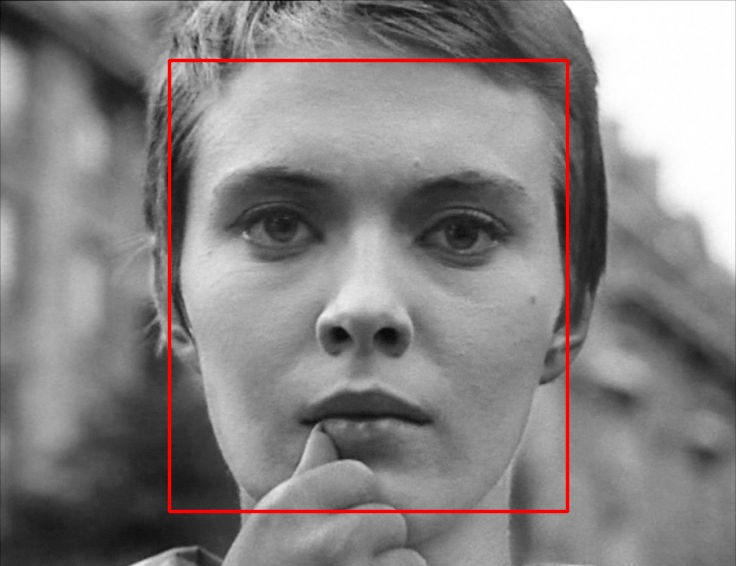

In [33]:
img = io.imread('https://github.com/astaileyyoung/CineFace/blob/main/research/notebooks/images/img_1.jpg?raw=true')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces = fd.detect(img)
if faces:
    fd.draw_faces(img, faces)
show_image(img)

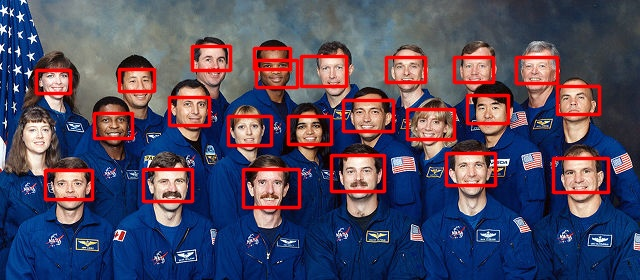

In [35]:
img = io.imread('https://github.com/astaileyyoung/CineFace/blob/main/research/notebooks/images/img_2.jpg?raw=true')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces = fd.detect(img)
if faces:
    fd.draw_faces(img, faces)
show_image(img)

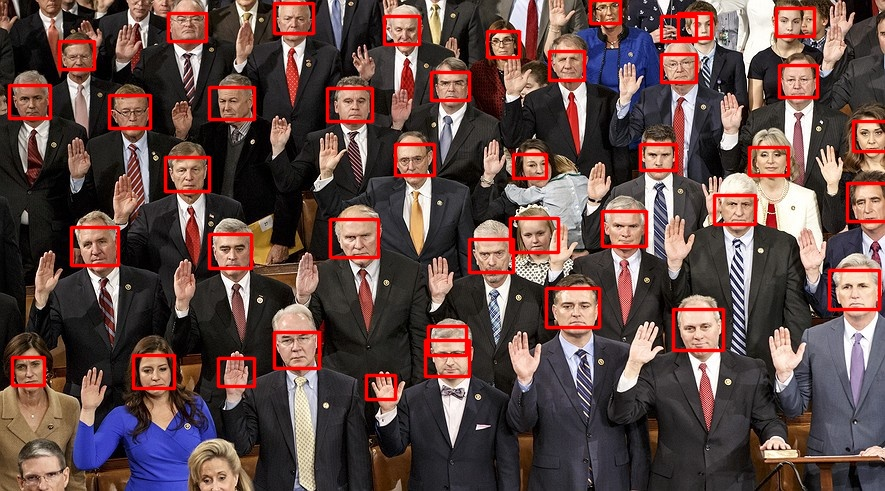

In [44]:
img = io.imread('https://github.com/astaileyyoung/CineFace/blob/main/research/notebooks/images/img_3.jpg?raw=true')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces = fd.detect(img)
if faces:
    fd.draw_faces(img, faces)
show_image(img)

In [45]:
cv2.imwrite('./img_3_masked.jpg', img)

True

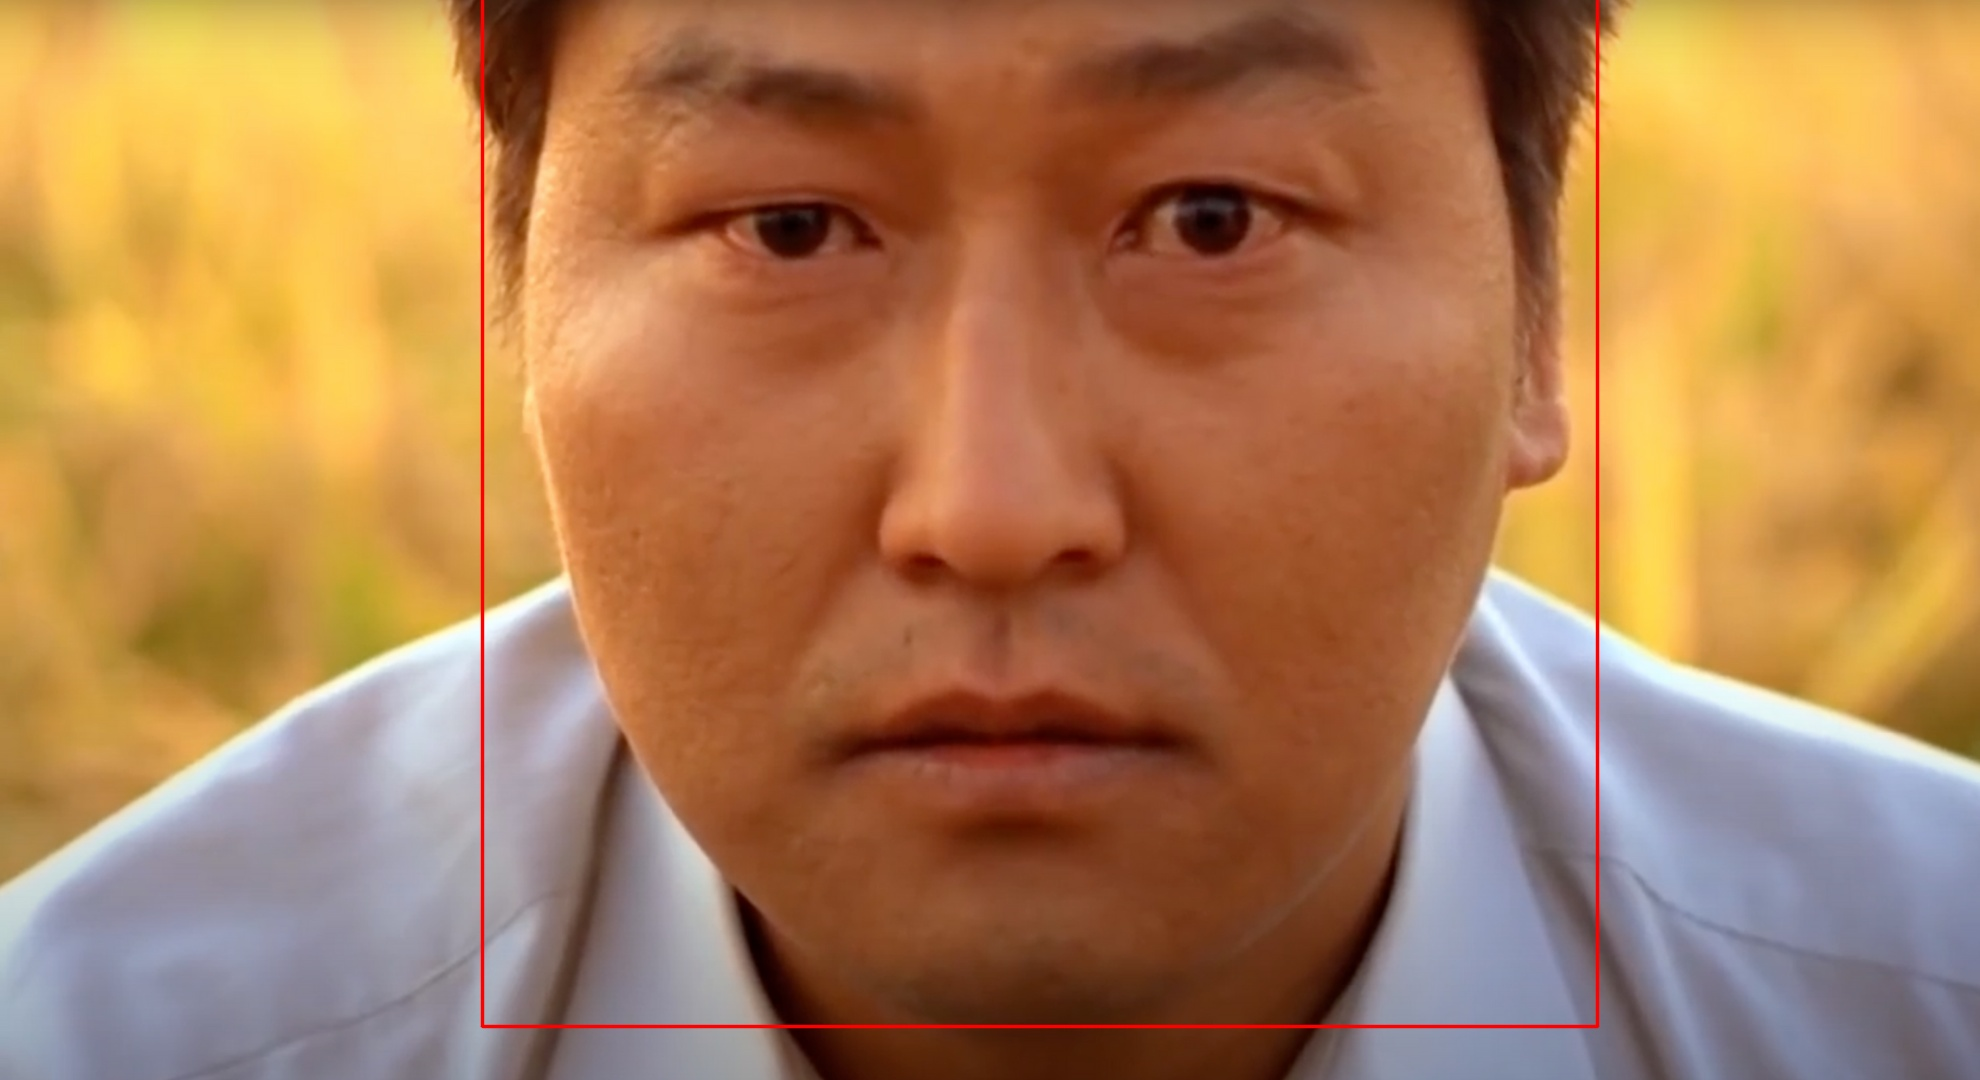

In [37]:
img = io.imread('https://github.com/astaileyyoung/CineFace/blob/main/research/notebooks/images/img_4.jpg?raw=true')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces = fd.detect(img)
if faces:
    fd.draw_faces(img, faces)
show_image(img)

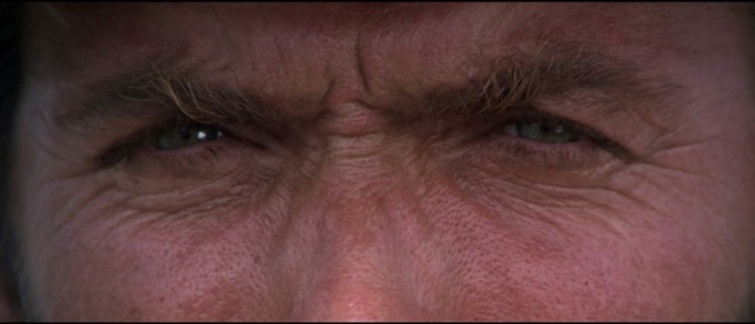

In [38]:
img = io.imread('https://github.com/astaileyyoung/CineFace/blob/main/research/notebooks/images/img_5.jpg?raw=true')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces = fd.detect(img)
if faces:
    fd.draw_faces(img, faces)
show_image(img)

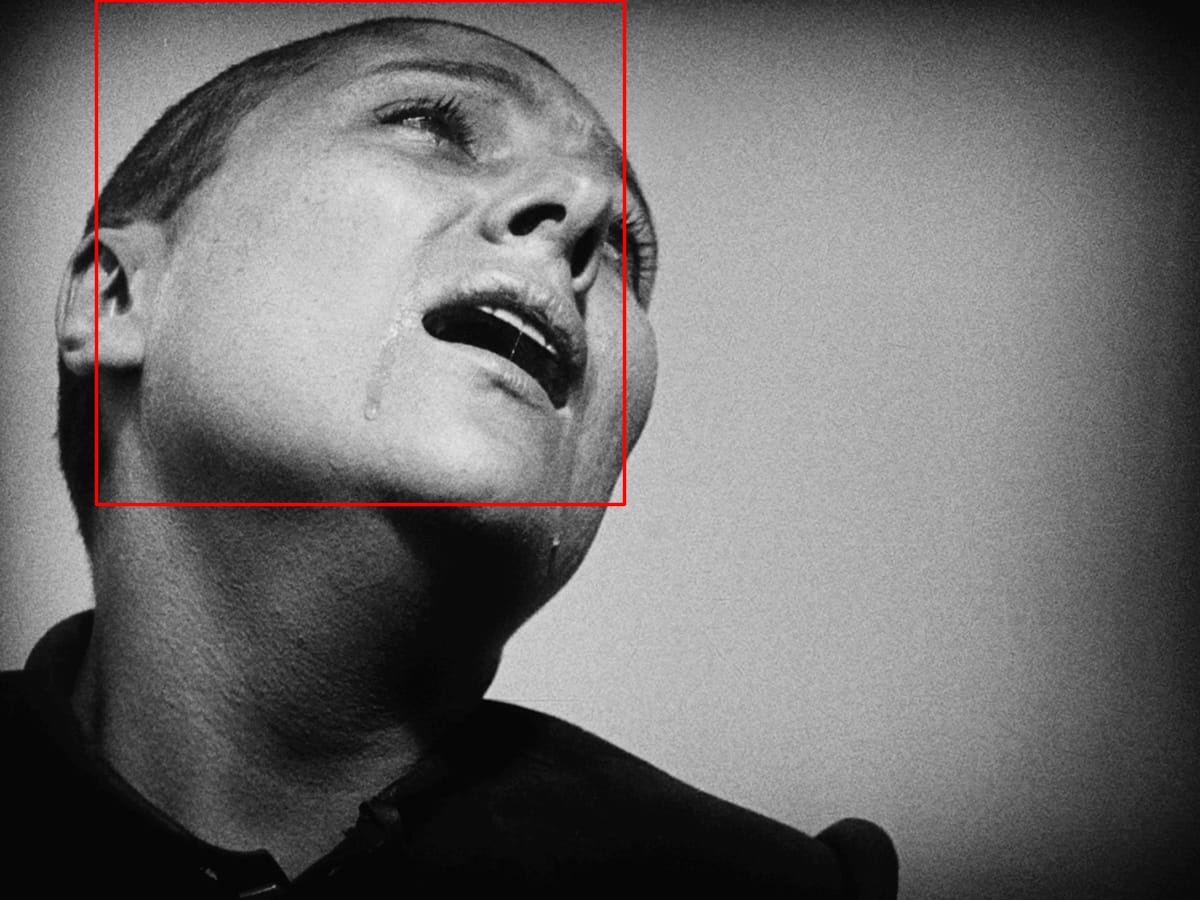

In [39]:
img = io.imread('https://github.com/astaileyyoung/CineFace/blob/main/research/notebooks/images/img_6.jpg?raw=true')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces = fd.detect(img)
if faces:
    fd.draw_faces(img, faces)
show_image(img)

In [42]:
cv2.imwrite('./img_6_masked.jpg', img)

True

In [46]:
from google.colab import files
files.download('./img_3_masked.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>